In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import numpy as np
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Running on ", device)

# Load the data
FirstData = np.load("fullsky4catgaia.npy", allow_pickle=True)

# Split the data into features and labels
X = FirstData[:, 1:-1]  # All columns except the last one and first one
y = FirstData[:, -1]    # The last column
ypreencode = y

# Use LabelEncoder instead of OneHotEncoder
encoder = LabelEncoder()
y = encoder.fit_transform(y.reshape(-1, 1))

# Convert y to a PyTorch tensor and move to the GPU (if available)
y = torch.tensor(y, dtype=torch.long).to(device)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y.cpu().numpy(), test_size=0.25, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

# Create PyTorch Datasets and DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

# Define the neural network model
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 40)
        self.fc2 = nn.Linear(40, 60)
        self.fc3 = nn.Linear(60, 60)
        self.fc4 = nn.Linear(60, 60)
        self.fc5 = nn.Linear(60, output_size)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.fc5(x)
        return x

# Calculate class weights
class_counts = np.bincount(y_train_tensor.cpu().numpy())
total_samples = sum(class_counts)
class_weights = [total_samples / count for count in class_counts]
class_weights = torch.tensor(np.clip(class_weights, 0, 100), dtype=torch.float32).to(device)

# Initialize the model, loss function, and optimizer
input_size = X_train.shape[1]
output_size = len(np.unique(ypreencode))
model = NeuralNetwork(input_size, output_size).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=0.004)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

# Early stopping
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# Function to calculate accuracy
def calculate_accuracy(loader, model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in loader:
            outputs = model(X_batch)
            _, predicted = torch.max(outputs.data, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
    return correct / total

# Training the model with a loading bar, early stopping, and adaptive learning rate
epochs = 300
early_stopping = EarlyStopping(patience=20, min_delta=0.001)
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{epochs}', unit='batch') as pbar:
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            pbar.set_postfix({'Loss': f'{running_loss/len(train_loader):.4f}'})
            pbar.update(1)

    # Validate the model
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()

    val_loss /= len(test_loader)
    scheduler.step(val_loss)  # Step the scheduler
    print(f'\nValidation Loss after Epoch {epoch+1}: {val_loss:.4f}')

    # Check early stopping
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping")
        break

    # Calculate and print the test accuracy after each epoch
    test_accuracy = calculate_accuracy(test_loader, model)
    print(f'Test Accuracy after Epoch {epoch+1}: {test_accuracy:.4f}')


Running on  cuda


C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/300: 100%|██████████| 1347/1347 [00:10<00:00, 131.55batch/s, Loss=1.3112]



Validation Loss after Epoch 1: 1.1104
Test Accuracy after Epoch 1: 0.6740


Epoch 2/300: 100%|██████████| 1347/1347 [00:10<00:00, 128.81batch/s, Loss=1.0768]



Validation Loss after Epoch 2: 1.0517
Test Accuracy after Epoch 2: 0.7808


Epoch 3/300: 100%|██████████| 1347/1347 [00:10<00:00, 133.64batch/s, Loss=1.0085]



Validation Loss after Epoch 3: 1.0107
Test Accuracy after Epoch 3: 0.6783


Epoch 4/300: 100%|██████████| 1347/1347 [00:10<00:00, 134.13batch/s, Loss=0.9643]



Validation Loss after Epoch 4: 0.9681
Test Accuracy after Epoch 4: 0.7615


Epoch 5/300: 100%|██████████| 1347/1347 [00:09<00:00, 135.58batch/s, Loss=0.9354]



Validation Loss after Epoch 5: 0.9417
Test Accuracy after Epoch 5: 0.7625


Epoch 6/300: 100%|██████████| 1347/1347 [00:10<00:00, 133.03batch/s, Loss=0.9113]



Validation Loss after Epoch 6: 0.9154
Test Accuracy after Epoch 6: 0.7764


Epoch 7/300: 100%|██████████| 1347/1347 [00:09<00:00, 134.95batch/s, Loss=0.8972]



Validation Loss after Epoch 7: 0.9197
Test Accuracy after Epoch 7: 0.7674


Epoch 8/300: 100%|██████████| 1347/1347 [00:10<00:00, 132.80batch/s, Loss=0.8790]



Validation Loss after Epoch 8: 0.9255
Test Accuracy after Epoch 8: 0.7791


Epoch 9/300: 100%|██████████| 1347/1347 [00:10<00:00, 132.14batch/s, Loss=0.8722]



Validation Loss after Epoch 9: 0.8918
Test Accuracy after Epoch 9: 0.7734


Epoch 10/300: 100%|██████████| 1347/1347 [00:10<00:00, 131.59batch/s, Loss=0.8689]



Validation Loss after Epoch 10: 0.8819
Test Accuracy after Epoch 10: 0.7795


Epoch 11/300: 100%|██████████| 1347/1347 [00:10<00:00, 131.70batch/s, Loss=0.8531]



Validation Loss after Epoch 11: 0.8719
Test Accuracy after Epoch 11: 0.7780


Epoch 12/300: 100%|██████████| 1347/1347 [00:10<00:00, 132.37batch/s, Loss=0.8442]



Validation Loss after Epoch 12: 0.8798
Test Accuracy after Epoch 12: 0.7786


Epoch 13/300: 100%|██████████| 1347/1347 [00:09<00:00, 134.91batch/s, Loss=0.8432]



Validation Loss after Epoch 13: 0.8637
Test Accuracy after Epoch 13: 0.7807


Epoch 14/300: 100%|██████████| 1347/1347 [00:10<00:00, 134.04batch/s, Loss=0.8369]



Validation Loss after Epoch 14: 0.8649
Test Accuracy after Epoch 14: 0.8106


Epoch 15/300: 100%|██████████| 1347/1347 [00:10<00:00, 133.22batch/s, Loss=0.8270]



Validation Loss after Epoch 15: 0.8823
Test Accuracy after Epoch 15: 0.7803


Epoch 16/300: 100%|██████████| 1347/1347 [00:10<00:00, 127.02batch/s, Loss=0.8269]



Validation Loss after Epoch 16: 0.8761
Test Accuracy after Epoch 16: 0.7904


Epoch 17/300: 100%|██████████| 1347/1347 [00:10<00:00, 130.66batch/s, Loss=0.8226]



Validation Loss after Epoch 17: 0.8821
Test Accuracy after Epoch 17: 0.7788


Epoch 18/300: 100%|██████████| 1347/1347 [00:10<00:00, 133.02batch/s, Loss=0.7275]



Validation Loss after Epoch 18: 0.7754
Test Accuracy after Epoch 18: 0.8001


Epoch 19/300: 100%|██████████| 1347/1347 [00:10<00:00, 134.61batch/s, Loss=0.6958]



Validation Loss after Epoch 19: 0.7639
Test Accuracy after Epoch 19: 0.8019


Epoch 20/300: 100%|██████████| 1347/1347 [00:10<00:00, 132.32batch/s, Loss=0.6861]



Validation Loss after Epoch 20: 0.7622
Test Accuracy after Epoch 20: 0.8165


Epoch 21/300: 100%|██████████| 1347/1347 [00:10<00:00, 131.48batch/s, Loss=0.6791]



Validation Loss after Epoch 21: 0.7602
Test Accuracy after Epoch 21: 0.7999


Epoch 22/300: 100%|██████████| 1347/1347 [00:10<00:00, 132.23batch/s, Loss=0.6725]



Validation Loss after Epoch 22: 0.7571
Test Accuracy after Epoch 22: 0.8119


Epoch 23/300: 100%|██████████| 1347/1347 [00:10<00:00, 131.64batch/s, Loss=0.6685]



Validation Loss after Epoch 23: 0.7547
Test Accuracy after Epoch 23: 0.8013


Epoch 24/300: 100%|██████████| 1347/1347 [00:10<00:00, 128.87batch/s, Loss=0.6645]



Validation Loss after Epoch 24: 0.7544
Test Accuracy after Epoch 24: 0.8186


Epoch 25/300: 100%|██████████| 1347/1347 [00:10<00:00, 130.60batch/s, Loss=0.6606]



Validation Loss after Epoch 25: 0.7535
Test Accuracy after Epoch 25: 0.8061


Epoch 26/300: 100%|██████████| 1347/1347 [00:10<00:00, 131.31batch/s, Loss=0.6567]



Validation Loss after Epoch 26: 0.7543
Test Accuracy after Epoch 26: 0.8238


Epoch 27/300: 100%|██████████| 1347/1347 [00:10<00:00, 131.21batch/s, Loss=0.6538]



Validation Loss after Epoch 27: 0.7542
Test Accuracy after Epoch 27: 0.8064


Epoch 28/300: 100%|██████████| 1347/1347 [00:10<00:00, 131.82batch/s, Loss=0.6512]



Validation Loss after Epoch 28: 0.7543
Test Accuracy after Epoch 28: 0.8163


Epoch 29/300: 100%|██████████| 1347/1347 [00:10<00:00, 133.41batch/s, Loss=0.6487]



Validation Loss after Epoch 29: 0.7507
Test Accuracy after Epoch 29: 0.8085


Epoch 30/300: 100%|██████████| 1347/1347 [00:10<00:00, 131.50batch/s, Loss=0.6465]



Validation Loss after Epoch 30: 0.7508
Test Accuracy after Epoch 30: 0.8183


Epoch 31/300: 100%|██████████| 1347/1347 [00:10<00:00, 130.71batch/s, Loss=0.6436]



Validation Loss after Epoch 31: 0.7482
Test Accuracy after Epoch 31: 0.8156


Epoch 32/300: 100%|██████████| 1347/1347 [00:10<00:00, 130.65batch/s, Loss=0.6412]



Validation Loss after Epoch 32: 0.7526
Test Accuracy after Epoch 32: 0.8192


Epoch 33/300: 100%|██████████| 1347/1347 [00:10<00:00, 133.36batch/s, Loss=0.6388]



Validation Loss after Epoch 33: 0.7510
Test Accuracy after Epoch 33: 0.8206


Epoch 34/300: 100%|██████████| 1347/1347 [00:10<00:00, 134.01batch/s, Loss=0.6373]



Validation Loss after Epoch 34: 0.7509
Test Accuracy after Epoch 34: 0.8152


Epoch 35/300: 100%|██████████| 1347/1347 [00:10<00:00, 132.81batch/s, Loss=0.6365]



Validation Loss after Epoch 35: 0.7543
Test Accuracy after Epoch 35: 0.8215


Epoch 36/300: 100%|██████████| 1347/1347 [00:08<00:00, 160.97batch/s, Loss=0.6217]



Validation Loss after Epoch 36: 0.7436
Test Accuracy after Epoch 36: 0.8159


Epoch 37/300: 100%|██████████| 1347/1347 [00:07<00:00, 187.82batch/s, Loss=0.6177]



Validation Loss after Epoch 37: 0.7435
Test Accuracy after Epoch 37: 0.8185


Epoch 38/300: 100%|██████████| 1347/1347 [00:07<00:00, 187.52batch/s, Loss=0.6158]



Validation Loss after Epoch 38: 0.7438
Test Accuracy after Epoch 38: 0.8177


Epoch 39/300: 100%|██████████| 1347/1347 [00:06<00:00, 196.81batch/s, Loss=0.6162]



Validation Loss after Epoch 39: 0.7436
Test Accuracy after Epoch 39: 0.8187


Epoch 40/300: 100%|██████████| 1347/1347 [00:07<00:00, 184.82batch/s, Loss=0.6161]



Validation Loss after Epoch 40: 0.7442
Test Accuracy after Epoch 40: 0.8172


Epoch 41/300: 100%|██████████| 1347/1347 [00:07<00:00, 190.95batch/s, Loss=0.6154]



Validation Loss after Epoch 41: 0.7440
Test Accuracy after Epoch 41: 0.8180


Epoch 42/300: 100%|██████████| 1347/1347 [00:07<00:00, 188.13batch/s, Loss=0.6129]



Validation Loss after Epoch 42: 0.7436
Test Accuracy after Epoch 42: 0.8188


Epoch 43/300: 100%|██████████| 1347/1347 [00:07<00:00, 188.97batch/s, Loss=0.6130]



Validation Loss after Epoch 43: 0.7436
Test Accuracy after Epoch 43: 0.8182


Epoch 44/300: 100%|██████████| 1347/1347 [00:07<00:00, 189.80batch/s, Loss=0.6125]



Validation Loss after Epoch 44: 0.7436
Test Accuracy after Epoch 44: 0.8187


Epoch 45/300: 100%|██████████| 1347/1347 [00:07<00:00, 191.01batch/s, Loss=0.6132]



Validation Loss after Epoch 45: 0.7435
Test Accuracy after Epoch 45: 0.8179


Epoch 46/300: 100%|██████████| 1347/1347 [00:07<00:00, 177.77batch/s, Loss=0.6127]



Validation Loss after Epoch 46: 0.7435
Test Accuracy after Epoch 46: 0.8181


Epoch 47/300: 100%|██████████| 1347/1347 [00:07<00:00, 188.81batch/s, Loss=0.6129]



Validation Loss after Epoch 47: 0.7435
Test Accuracy after Epoch 47: 0.8182


Epoch 48/300: 100%|██████████| 1347/1347 [00:07<00:00, 188.76batch/s, Loss=0.6133]



Validation Loss after Epoch 48: 0.7435
Test Accuracy after Epoch 48: 0.8182


Epoch 49/300: 100%|██████████| 1347/1347 [00:07<00:00, 189.85batch/s, Loss=0.6128]



Validation Loss after Epoch 49: 0.7435
Test Accuracy after Epoch 49: 0.8184


Epoch 50/300: 100%|██████████| 1347/1347 [00:07<00:00, 187.33batch/s, Loss=0.6125]



Validation Loss after Epoch 50: 0.7435
Test Accuracy after Epoch 50: 0.8184


Epoch 51/300: 100%|██████████| 1347/1347 [00:07<00:00, 188.41batch/s, Loss=0.6131]



Validation Loss after Epoch 51: 0.7435
Test Accuracy after Epoch 51: 0.8183


Epoch 52/300: 100%|██████████| 1347/1347 [00:07<00:00, 188.15batch/s, Loss=0.6127]



Validation Loss after Epoch 52: 0.7435
Test Accuracy after Epoch 52: 0.8183


Epoch 53/300: 100%|██████████| 1347/1347 [00:07<00:00, 189.97batch/s, Loss=0.6123]



Validation Loss after Epoch 53: 0.7435
Test Accuracy after Epoch 53: 0.8183


Epoch 54/300: 100%|██████████| 1347/1347 [00:07<00:00, 189.57batch/s, Loss=0.6137]



Validation Loss after Epoch 54: 0.7435
Test Accuracy after Epoch 54: 0.8183


Epoch 55/300: 100%|██████████| 1347/1347 [00:07<00:00, 188.66batch/s, Loss=0.6127]



Validation Loss after Epoch 55: 0.7435
Test Accuracy after Epoch 55: 0.8183


Epoch 56/300: 100%|██████████| 1347/1347 [00:06<00:00, 197.47batch/s, Loss=0.6132]



Validation Loss after Epoch 56: 0.7435
Early stopping


C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classificati

Classification Report:
               precision    recall  f1-score   support

         AB*       0.12      0.35      0.18       221
         Ae*       0.00      0.00      0.00        11
         BS*       0.50      0.82      0.62       676
         Be*       0.64      0.88      0.74       315
          C*       0.53      0.91      0.67      2602
         Ce*       0.29      0.53      0.38       189
         HB*       0.54      0.68      0.60      5001
          HH       0.00      0.00      0.00         3
         HS*       0.76      0.94      0.84       760
         LP*       0.98      0.80      0.88     49420
         MS*       0.00      0.00      0.00        12
         Mi*       0.51      0.89      0.65      5212
         OH*       0.00      0.00      0.00        22
         Or*       0.32      0.32      0.32       113
          PN       0.06      0.05      0.05        83
         Psr       0.00      0.00      0.00        15
         RG*       0.74      0.69      0.71     10762
   

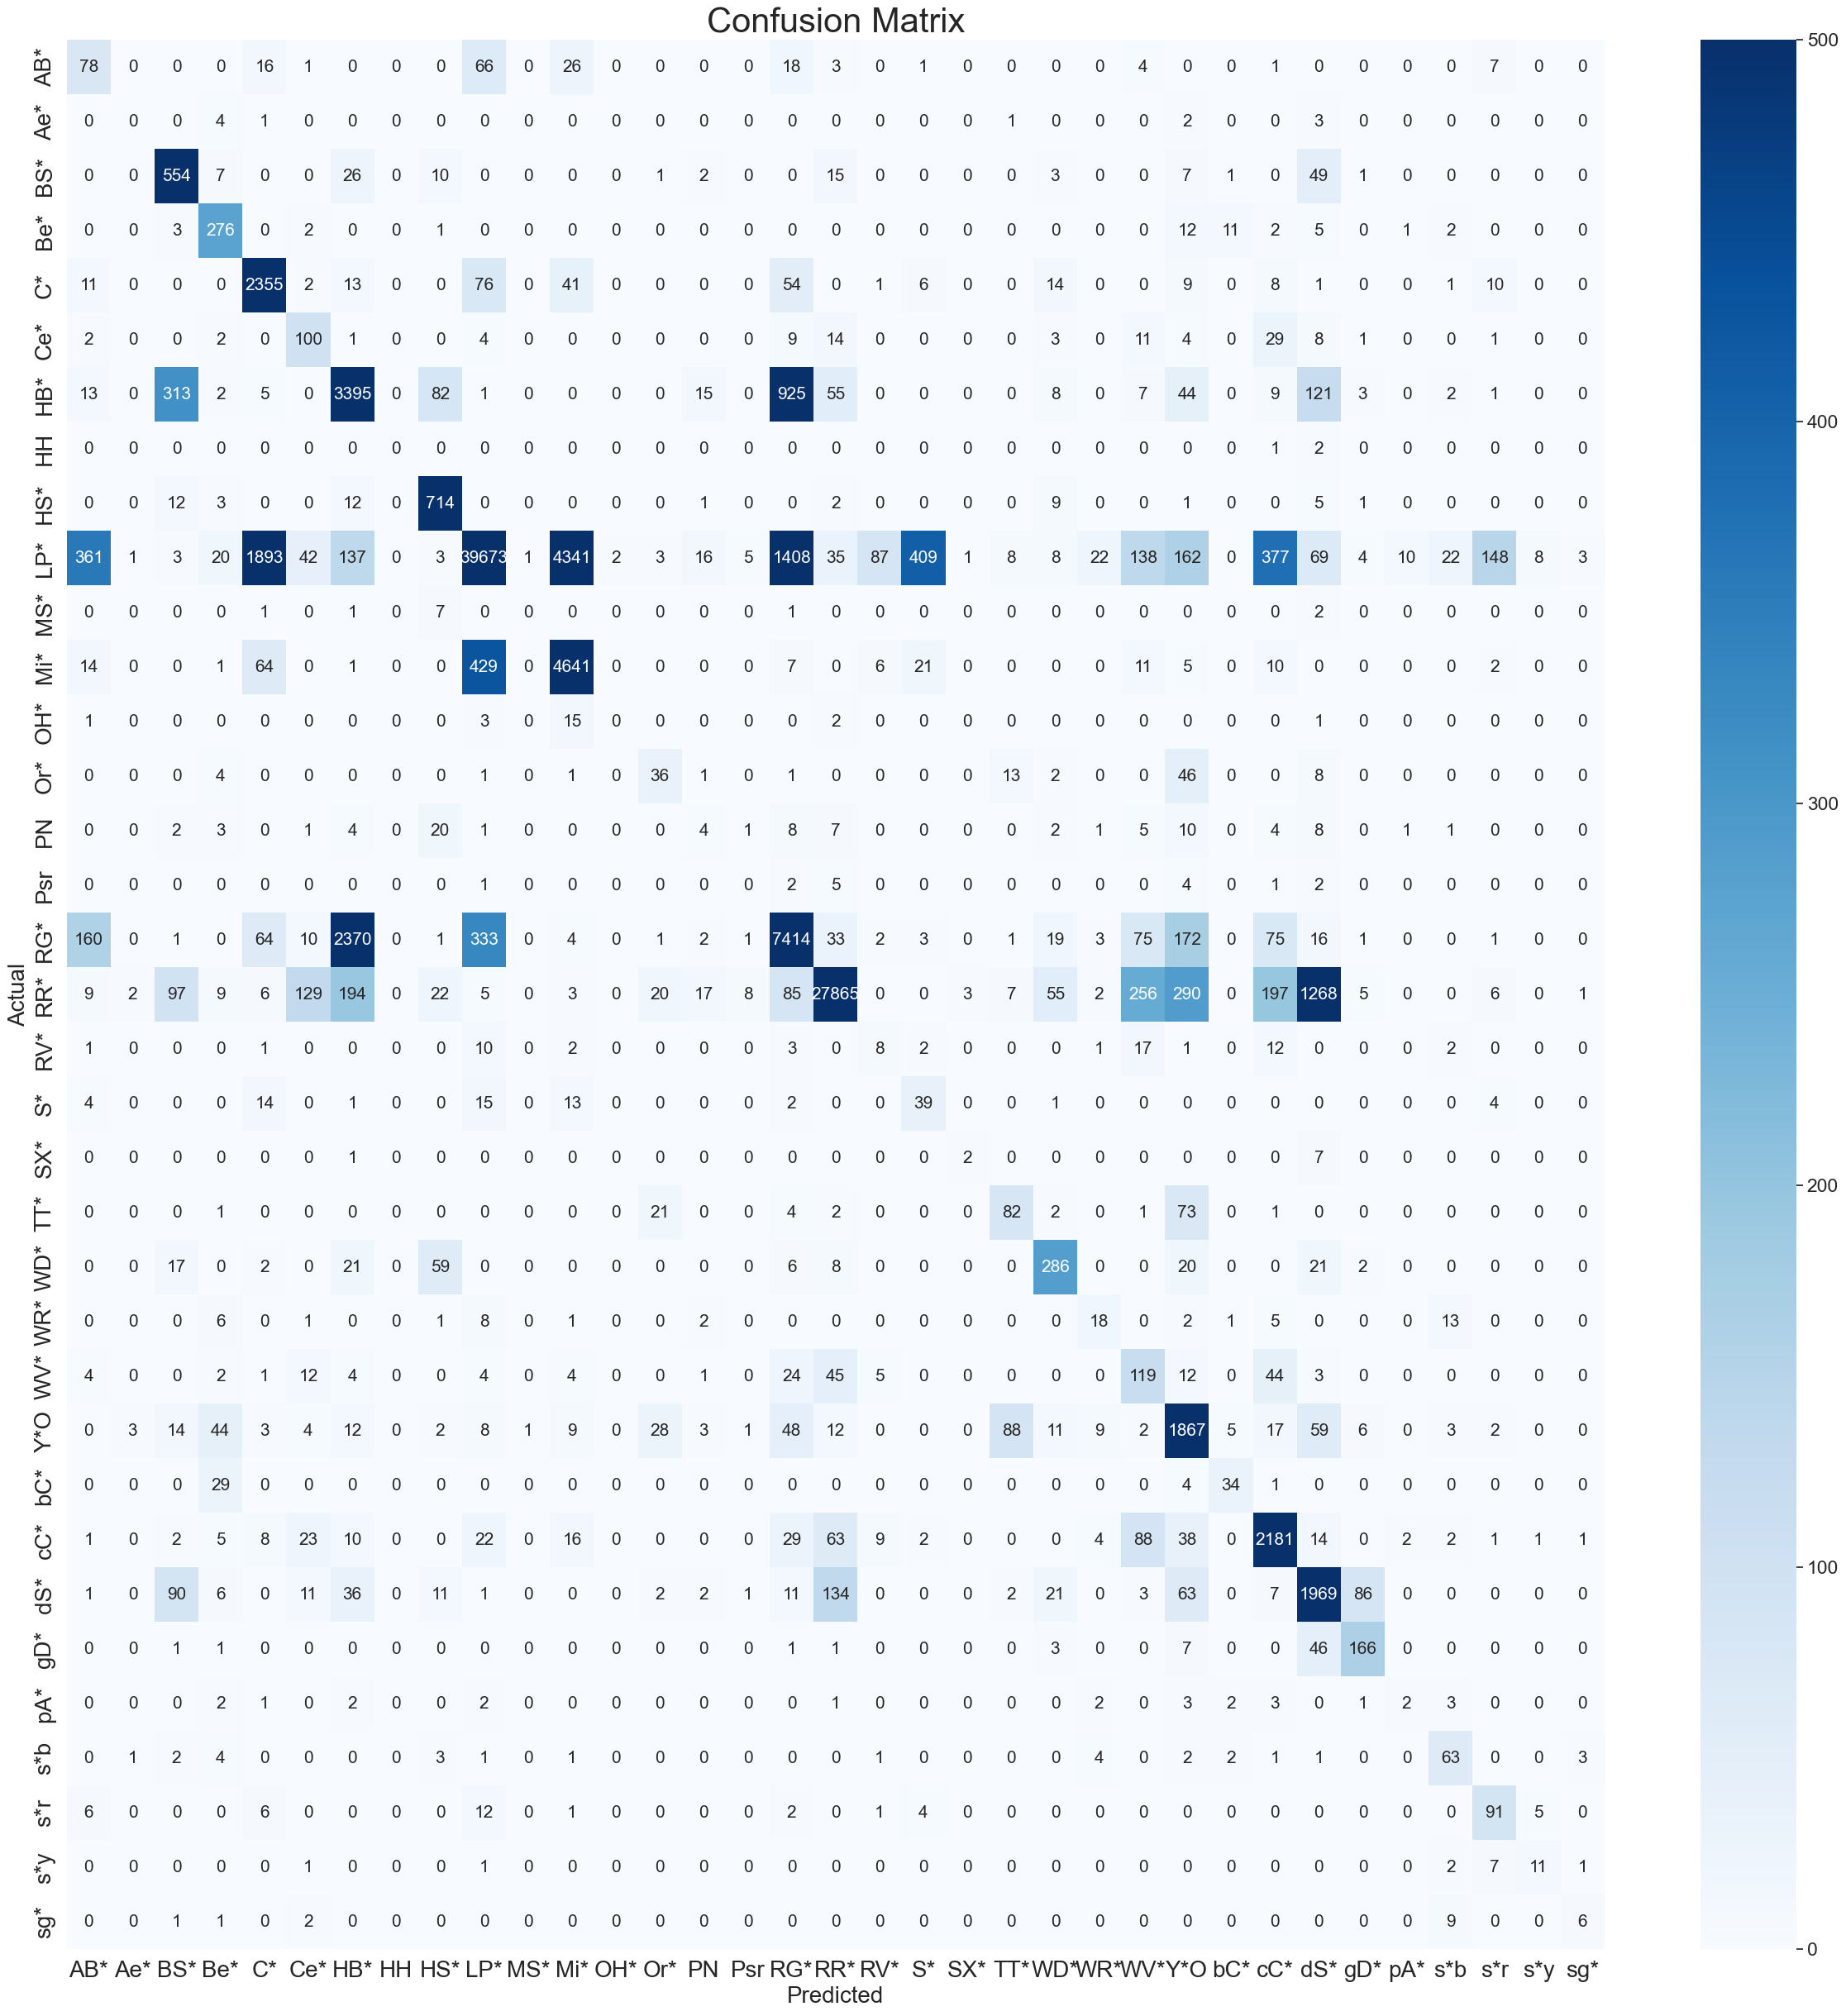

In [8]:
# Load the saved model
#model = NeuralNetwork(input_size, output_size).to(device)
#model.load_state_dict(torch.load('star_classifier_Exp2.pth'))
model.to(device)

# Make predictions on the test set
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs.data, 1)
        # _, labels = torch.max(y_batch.data, 1)  # Remove this line
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())  # Just use y_batch directly

# Get the unique labels from your predictions and true labels
unique_labels = np.unique(all_labels)

# Print the classification report for accuracy per category
report = classification_report(all_labels, all_preds, labels=unique_labels, target_names=encoder.classes_[unique_labels])
print("Classification Report:\n", report)


# Generate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(30, 30))
sns.set(font_scale=1.5)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', vmin=0, vmax=500, 
            xticklabels=encoder.classes_, yticklabels=encoder.classes_, 
            annot_kws={"size": 15})
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Actual', fontsize=20)
plt.title('Confusion Matrix', fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()


# Chat's improved version gaia 